Tokenization and encoding

In [10]:
with open('../data/expressions.txt') as f:
    data = list(map(lambda x: x.rstrip('\n'), f.readlines()))

data[0]

'(x1 - 0.125192826477114) + 0.43174347075339936'

In [14]:
import sympy as sp

expr = sp.parse_expr(data[1])
expr

sin(exp(0.4609526466213322*sin(x1)))

In [22]:
# Get all properties of expr
print("Expression:", expr)
print("Type:", type(expr))
print("Class:", expr.__class__)
print("Arguments:", expr.args)
print("Free symbols:", expr.free_symbols)
print("Is atomic:", expr.is_Atom)

if hasattr(expr, 'func'):
    print("Function:", expr.func)

if hasattr(expr, 'is_commutative'):
    print("Is commutative:", expr.is_commutative)

if hasattr(expr, 'is_real'):
    print("Is real:", expr.is_real)

if hasattr(expr, 'is_integer'):
    print("Is integer:", expr.is_integer)

if hasattr(expr, 'is_rational'):
    print("Is rational:", expr.is_rational)

if hasattr(expr, 'is_algebraic'):
    print("Is algebraic:", expr.is_algebraic)

if hasattr(expr, 'is_transcendental'):
    print("Is transcendental:", expr.is_transcendental)

# Get the structure of the expression
print("\nExpression structure:")
print(expr.structurally_equal(expr, check_numerics=False))

# If it's an operation, get the operation type
if hasattr(expr, 'is_Add') and expr.is_Add:
    print("Operation: Addition")
elif hasattr(expr, 'is_Mul') and expr.is_Mul:
    print("Operation: Multiplication")
elif hasattr(expr, 'is_Pow') and expr.is_Pow:
    print("Operation: Exponentiation")

# If it's a function, get the function name
if hasattr(expr, 'func') and expr.func != expr.__class__:
    print("Function name:", expr.func.__name__)




Expression: sin(exp(0.4609526466213322*sin(x1)))
Type: sin
Class: sin
Arguments: (exp(0.4609526466213322*sin(x1)),)
Free symbols: {x1}
Is atomic: False
Function: sin
Is commutative: True
Is real: None
Is integer: None
Is rational: None
Is algebraic: None
Is transcendental: None

Expression structure:


AttributeError: 'sin' object has no attribute 'structurally_equal'

In [26]:
a = ['sin', 'cos', 'tan', 'exp', 'log']
a.index('cos')

1

In [23]:
from sympy import pi, sin
from sympy.abc import a,x,y

# Turn into prefix notation first
# Then 1-hot encode with xVal

def depth_first_traverse(expr):
    print(f'Operator: {expr.func}')
    for arg in expr.args:
        print(f'Traversing: {arg}')
        depth_first_traverse(arg)
    if len(expr.args) == 0:
        # we reached a leaf of the tree
        print(f'Reached leaf node: {expr}')
    else:
        # do something with compound expr
        print(f'Reached compound node: {expr}')
depth_first_traverse(sin(a*x*pi+1.5)/y)




Operator: <class 'sympy.core.mul.Mul'>
Traversing: 1/y
Operator: <class 'sympy.core.power.Pow'>
Traversing: y
Operator: <class 'sympy.core.symbol.Symbol'>
Reached leaf node: y
Traversing: -1
Operator: <class 'sympy.core.numbers.NegativeOne'>
Reached leaf node: -1
Reached compound node: 1/y
Traversing: sin(pi*a*x + 1.5)
Operator: sin
Traversing: pi*a*x + 1.5
Operator: <class 'sympy.core.add.Add'>
Traversing: 1.50000000000000
Operator: <class 'sympy.core.numbers.Float'>
Reached leaf node: 1.50000000000000
Traversing: pi*a*x
Operator: <class 'sympy.core.mul.Mul'>
Traversing: pi
Operator: <class 'sympy.core.numbers.Pi'>
Reached leaf node: pi
Traversing: a
Operator: <class 'sympy.core.symbol.Symbol'>
Reached leaf node: a
Traversing: x
Operator: <class 'sympy.core.symbol.Symbol'>
Reached leaf node: x
Reached compound node: pi*a*x
Reached compound node: pi*a*x + 1.5
Reached compound node: sin(pi*a*x + 1.5)
Reached compound node: sin(pi*a*x + 1.5)/y


In [28]:
sp.parse_expr('sin(a*x*pi+1.5)/y')

sin(pi*a*x + 1.5)/y

In [75]:
import h5py

# Load the dataset
with h5py.File('../data/dataset.h5', 'r') as f:
    raw = list(map(lambda x: str(x)[2:-1], f['raw'][()]))
    dataset = f['dataset'][()]
    encoding = list(map(lambda x: str(x)[2:-1], f['encoding'][()]))

#### Decoding and evaluation

In [125]:
import sympy

# Decode the onehot matrix into seq
def onehot_to_seq(onehot_matrix):
    seq = []
    for i, token_id in enumerate(onehot_matrix[:, :-1].argmax(axis=1)):
        if encoding[token_id] == '[PAD]':
            break
        elif encoding[token_id] == '[NUM]':
            seq.append(str(onehot_matrix[i, -1]))
        else:
            seq.append(encoding[token_id])
    return seq

binops = ['+', '-', '*', '/', '^', '(', ')']
unops = ['sin', 'cos', 'tan', 'exp', 'log']

def seq_to_infix(prefix):
    stack = []
    
    # read prefix in reverse order
    i = len(prefix) - 1
    while i >= 0:
        symbol = prefix[i]
        if symbol in binops:
            str = "(" + stack.pop() + symbol + stack.pop() + ")"
            stack.append(str)
            i -= 1
        elif symbol in unops:
            str = symbol + "(" + stack.pop() + ")"
            stack.append(str)
            i -= 1
        else:
            stack.append(symbol)
            i -= 1
    return stack.pop()

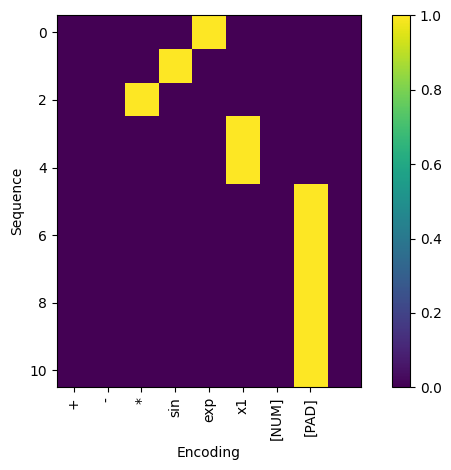

In [140]:
from matplotlib import pyplot as plt

def plot_onehot(onehot_matrix, labels=None):
    plt.imshow(onehot_matrix)
    plt.ylabel('Sequence')
    plt.xlabel('Encoding')
    plt.xticks(range(len(encoding)), encoding, rotation='vertical')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plot_onehot(dataset[3, ...])


In [132]:

for onehot_matrix, raw_expr_str in zip(dataset[1:1000, ...], raw[1:1000]):
    # onehot_matrix = dataset[1, ...]
    seq = onehot_to_seq(onehot_matrix)
    infix_str = seq_to_infix(seq)
    expr = sympy.parse_expr(infix_str)

    expr_raw = sympy.parse_expr(raw_expr_str)

    # print(expr, '   ',  expr_raw)
    diff = sympy.simplify(expr-expr_raw).evalf(subs={'x1': 1e-3})
    assert diff < 1e-6, f'{diff} for {raw_expr_str} -> {expr}'
    # print(diff)

AssertionError: 0.00000696947861315010 for exp(exp(x1 + 1.2443581378370845)) -> exp(3.47070658489311*exp(x1))

In [165]:
import numpy as np

onehot_matrix = np.random.random([11, len(encoding)+1])


# seq = onehot_to_seq(onehot_matrix)
# infix_str = seq_to_infix(seq)
# expr = sympy.parse_expr(infix_str)
# expr

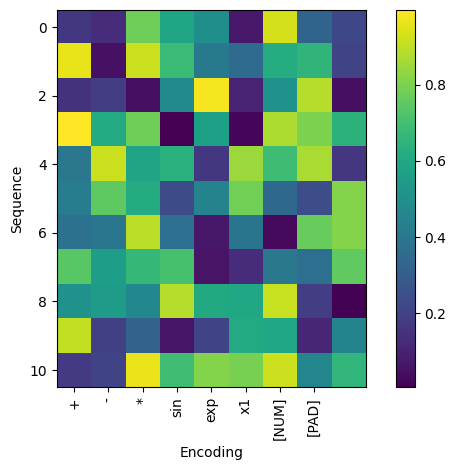

In [166]:
plot_onehot(onehot_matrix)

### Grammar

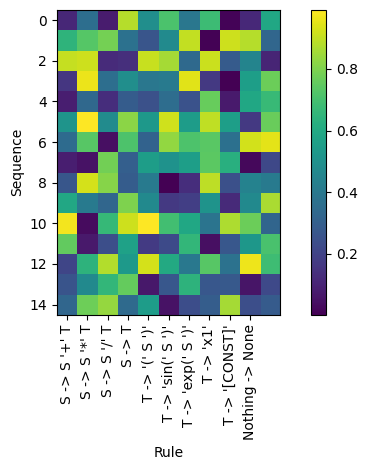

In [185]:
from matplotlib import pyplot as plt

def plot_onehot(onehot_matrix, grammar):
    plt.imshow(onehot_matrix)

    plt.ylabel('Sequence')
    plt.xlabel('Rule')
    xticks = grammar.productions()
    plt.xticks(range(len(xticks)), xticks, rotation='vertical')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

onehot_matrix = np.random.random([15, len(GCFG.productions())+1])
plot_onehot(onehot_matrix, GCFG)

In [196]:
import torch
from torch.autograd import Variable
from nltk import CFG, Nonterminal
from torch.distributions import Categorical

In [197]:
class Stack:
    """A simple first in last out stack.

    Args:
        grammar: an instance of nltk.CFG
        start_symbol: an instance of nltk.Nonterminal that is the
            start symbol the grammar
    """
    def __init__(self, grammar, start_symbol):
        self.grammar = grammar
        self._stack = [start_symbol]

    def pop(self):
        return self._stack.pop()

    def push(self, symbol):
        self._stack.append(symbol)

    def __str__(self):
        return str(self._stack)

    @property
    def nonempty(self):
        return bool(self._stack)


def get_mask(nonterminal, grammar, as_variable=False):
    if isinstance(nonterminal, Nonterminal):
        mask = [rule.lhs() == nonterminal for rule in grammar.productions()]
        mask = Variable(torch.FloatTensor(mask)) if as_variable else mask
        return mask
    else:
        raise ValueError('Input must be instance of nltk.Nonterminal')

def onehot_to_prod(onehot_matrix, grammar, start_symbol, sample=True, max_length=15):
    stack = Stack(grammar=grammar, start_symbol=start_symbol)

    logits = torch.tensor(onehot_matrix[:, :-1])
    numerical = onehot_matrix[:, -1]

    rules = []
    t = 0
    while stack.nonempty:
        alpha = stack.pop()
        mask = get_mask(alpha, stack.grammar, as_variable=True)
        probs = mask * logits[t].exp()
        probs = probs / probs.sum()
        
        if sample:
            m = Categorical(probs)
            i = m.sample()
        else:
            _, i = probs.max(-1) # argmax

        i = i.item()
        # select rule i
        rule = stack.grammar.productions()[i]
        rules.append(rule)
        # add rhs nonterminals to stack in reversed order
        for symbol in reversed(rule.rhs()):
            if isinstance(symbol, Nonterminal):
                stack.push(symbol)
        t += 1
        if t == max_length:
            break
    return rules


def prods_to_eq(prods, verbose=False):
    seq = [prods[0].lhs()]
    for prod in prods:
        if str(prod.lhs()) == 'Nothing':
            break
        for ix, s in enumerate(seq):
            if s == prod.lhs():
                seq = seq[:ix] + list(prod.rhs()) + seq[ix+1:]
                break
    try:
        return ''.join(seq)
    except TypeError:
        if verbose:
            print(f'Nonterminal found. {seq = }')
        return ''


In [192]:

print(get_mask(T, GCFG))



In [195]:
grammar = """
S -> S '+' T
S -> S '*' T
S -> S '/' T
S -> T
T -> '(' S ')'
T -> 'sin(' S ')'
T -> 'exp(' S ')'
T -> 'x1'
T -> '[CONST]'
Nothing -> None"""
GCFG = CFG.fromstring(grammar)
S, T = Nonterminal('S'), Nonterminal('T')

rules = onehot_to_prod(onehot_matrix, GCFG, S)
prods_to_eq(rules, verbose=True)

Nonterminal found. seq = ['x1', '+', 'x1', '+', 'sin(', 'exp(', S, ')', '*', T, '+', T, '+', T, ')', '*', T, '+', T, '/', T, '/', T]


''